# Lidar to Camera Mapping

---

In this exercise you will be given a set of points in 3D space from three different lidars, and a camera picture taken at the same time. Your task is to map the 3D points to the 2D image.  You should develop your pipeline based on the two 3D Pointclouds from different positions:

![3D Pointcloud](data/3d.png)

After combining transforming them to the same coordinate system, it should look like this:

![3D Pointcloud](data/3d_combined.png)

And the 2D image:

![2D Image](data/2d.png)

The output of your pipeline should be the 3D points mapped to the 2D image:

![3D to 2D](data/3d_to_2d.png)

---

**Used functions:**
The functions used are Transformation of 3D points and Project Points.


 

## Helper Functions

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# def transform_pointcloud(pointcloud, transformation_matrix):
#     # get the information from hdf5
#     x = pointcloud[0]
#     y = pointcloud[1]
#     z = pointcloud[2]

#     pointcloud_vector = np.array([x, y, z, np.ones(len(x))])
#     transformed_points = transformation_matrix@pointcloud_vector

#     return transformed_points[:-1]

def project_points(pointcloud, rotation_matrix, translation_vector, camera_matrix, camera_distorion_vector):
    projected_points, _ = cv2.projectPoints(
        pointcloud, 
        rotation_matrix, 
        translation_vector, 
        camera_matrix, 
        camera_distorion_vector
    )
    projected_points = np.array(projected_points[:,0,:]).transpose()
    return projected_points
    
def filter_points(projected_points, pointcloud, image_width, image_height):
    index_of_points_in_fov = np.where(
        (projected_points[0, :] < image_width) & 
        (projected_points[0, :] >= 0) &
        (projected_points[1, :] < image_height) & 
        (projected_points[1, :] >= 0) &
        (pointcloud[0, :] > 0)
    )[0]
    projected_points_in_fov = projected_points[:, index_of_points_in_fov]
    return projected_points_in_fov, index_of_points_in_fov

def calculate_distance_to_origin(pointcloud):
    distance = np.sqrt(
        np.power(pointcloud[:, 0],2)+ 
        np.power(pointcloud[:, 1],2)+
        np.power(pointcloud[:, 2],2)
    )
    return distance

def plot_3d_pointcloud(pointcloud):
    # Create a figure
    fig = plt.figure()
    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pointcloud[0], pointcloud[1], pointcloud[2], s=0.01)
    # axes must have same scale
    ax.set_box_aspect([np.ptp(pointcloud[0]), np.ptp(pointcloud[1]), np.ptp(pointcloud[2])])
    # Set labels for axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    # Show the plot
    plt.show()

def plot_mapped_points(projected_points_in_fov, image):
    # map = plt.cm.get_cmap('hsv', 256)
    plt.scatter(
        projected_points_in_fov[0,:], 
        projected_points_in_fov[1,:], 
        s=0.1, alpha=0.4
    )
    plt.imshow(image)
    plt.show()

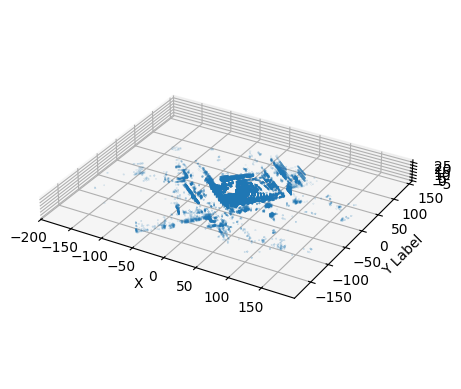

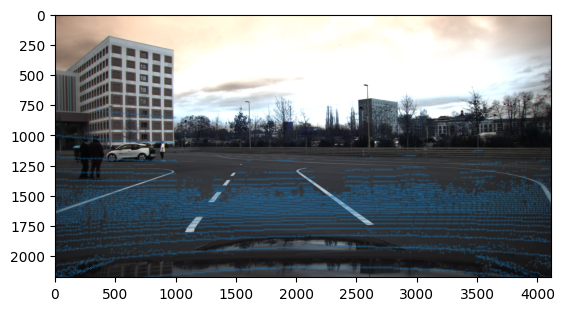

In [5]:
transformation_matrix_cam= np.array([
    [
        -0.01451152129761748,
        0.0014610053391659722,
        0.9998936349497528,
        0.5753084298786633
    ],
    [
        -0.9998913317881631,
        0.0025752882620655336,
        -0.014515250781826066,
        0.24285836369189612
    ],
    [
        -0.0025962212002911063,
        -0.9999956166672765,
        0.0014234752238661472,
        -0.029021191359694797
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
])

# calculate transformation matrices
transformation_matrix_lidar_to_cam = np.linalg.inv(transformation_matrix_cam) 

# transform matrix to rotation matrix and transformation vector which is necessary for opencv
rotation_matrix_lidar_to_cam = transformation_matrix_lidar_to_cam[:3,:3]
tranformation_vector_lidar_to_cam = transformation_matrix_lidar_to_cam[:3,3]
            
fx = 2368.9713701884807
fy = 2367.9863747315403
cx = 2018.412900237999
cy = 1517.467643964667
camera_matrix = np.array([
    [fx,0,cx],
    [0, fy, cy],
    [0, 0, 1]
])

k1 = -0.1727869525852468
k2 = 0.11006438235803445
k3 = -0.017348056154691954
k4 = 0.0
k5 = 0.0
k6 = 0.0
p1 = -0.0007982001760497525
p2 = -0.0006745297153541237
camera_distorion_vector = np.array([
    k1,
    k2,
    p1,
    p2,
    k3,
    k4,
    k5,
    k6
])

# read image
image = cv2.imread("data/image.png")

# read csv pointcloud
df_pointcloud = pd.read_csv("data/pointcloud.csv")
# np.array of shape (3, n) -> [x,y,z]
pointcloud = df_pointcloud.to_numpy().T

#TODO: Build your pipeline here

# plot 3d pointcloud
plot_3d_pointcloud(pointcloud)

# project points to image 
projected_points = project_points(pointcloud, rotation_matrix_lidar_to_cam, tranformation_vector_lidar_to_cam, camera_matrix, camera_distorion_vector)

# filter points in field of view
projected_points_in_fov, index_of_points_in_fov = filter_points(projected_points, pointcloud, image.shape[1], image.shape[0])

# plot mapped points
plot_mapped_points(projected_points_in_fov, image)


## Questions

1. Describe your pipeline.
2. Identify potential problems with your current pipeline (especially with transforming the position with the transformation matrix).
3. Why is mapping of 3D points to 2D image important in autonomous driving?